In [1]:
# plan

# - caclulate monthly Q for different land covers 
# - calculate how on average change in lang cover affect the change in runoff -> transport capacity -> TL case 



# plan
# 1 - calculate the monthly water yeild 
# 2 - plot average + spread per month 


In [2]:
import pandas as pd 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import os
import seaborn as sns


import functions



# calculate the monthly values in mm 

In [3]:
def water_balance_components_in_mm(hydro, column, area=4830.0):
    """
    Calculate the sum of water or sediment volume per month for a specific column, 
    and return the mean volumes across years.
    
    Parameters:
    hydro (pd.DataFrame): Input DataFrame with columns `D` (date) and the specified numeric column.
    column (str): The name of the column to calculate the volume for.
    area (float): Area in square meters used to scale the volumes. Default is 4830.0.
    
    Returns:
    pd.DataFrame: DataFrame with the calculated monthly volumes.
    """
    # Ensure `D` column is in datetime format
    hydro['D'] = pd.to_datetime(hydro['D'])

    if column == 'snowmelt':
        hydro['snowmelt'] = hydro['snowacc'].where(hydro['snowacc'] < 0).fillna(0)
    if column == 'snowacc2':
        hydro['snowacc2'] = hydro['snowacc'].where(hydro['snowacc'] > 0).fillna(0)
    if column == 'rainfall':
        hydro['rainfall'] = hydro['Pr'] - hydro['snowacc']
        hydro['rainfall'] = hydro['rainfall'].fillna(0)
        
    
    # Scale the specified column by the area
    hydro[column] = hydro[[column]]
    
    # Set 'D' as the index
    hydro = hydro.set_index('D')
    
    # Resample to monthly data and calculate the sum for each month for the specified column
    hydro_month = hydro[column].resample('M').sum()
    hydro_month = hydro_month.reset_index()
    
    # Extract year and month for grouping or further analysis
    hydro_month['year'] = hydro_month['D'].dt.year
    hydro_month['month'] = hydro_month['D'].dt.month
    
    return hydro_month


In [4]:
%%time

# column = 'Pr'  # Set the target column
location = 'mustang'

if location == 'langtang':
    folder_loc = '12a'
if location == 'mustang': 
    folder_loc = '13a'

output_path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/1july_hydro'

# Define the list of folder paths

folder_paths = [f'/Volumes/T7 Shield/202409_paper2_modelruns/May2025_30years/TL_data/1landcover/{location}_climate_cut',
                f'/Volumes/T7 Shield/202409_paper2_modelruns/May2025_30years/TL_data/2landcover/{location}_climate_cut',
                f'/Volumes/T7 Shield/202409_paper2_modelruns/May2025_30years/TL_data/3landcover/{location}_climate_cut',
                f'/Volumes/T7 Shield/202409_paper2_modelruns/May2025_30years/TL_data/4landcover/{location}_climate_cut',
                f'/Volumes/T7 Shield/202409_paper2_modelruns/May2025_30years/TL_data/5landcover/{location}_climate_cut']



# Load elevation data and define the output path
elevation = pd.read_csv(f'/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_and_elevation_with_labels_{location}.csv')[['cellnr2', 'band_data']]
elevation = elevation.transpose()
elevation_list = elevation.loc['cellnr2'].tolist() 


CPU times: user 7.59 ms, sys: 3.59 ms, total: 11.2 ms
Wall time: 16.1 ms


In [5]:
# loop over columns too 
columns = ['Ta', 'PET', 'AET', 'Q', 'snowacc2', 'snowmelt', 'glacier_melt', 'Pr', 'rainfall']
# columns = ['Pr', 'rainfall']
# columns = ['glacier_melt']
# columns = ['Ta']

In [6]:
%%time
print(columns)  # Ensure `columns` is defined as a list of column names

# Iterate over columns
for column in columns:
    print(f"Processing column: {column}")

    # Iterate over folder paths
    for folder_path in folder_paths:
        print(f"Processing folder: {folder_path}")

        output_folder = output_path

        # Extract "1landcover" from the folder path
        landcover_part = os.path.basename(os.path.dirname(folder_path))
        landcover_base = landcover_part.split('_')[0]  # This gives "1landcover"

        # Load timestep DataFrame (assuming Hydro.out exists in the `/12a/` subfolder for all folders)
        hydro_path = os.path.join(folder_path, folder_loc, 'Hydro.out')
        print(f"Checking Hydro.out path: {hydro_path}")

        if not os.path.isfile(hydro_path):
            print(f"Hydro.out not found in {hydro_path}")
            continue  # Skip this folder_path if the main Hydro.out is missing

        # Load the Hydro.out file for timestep calculation
        try:
            dfts = pd.read_csv(hydro_path)
            df = water_balance_components_in_mm(dfts, column, area=4830.0)
            df = df[['month', 'year']]
        except Exception as e:
            print(f"Error loading timestep file: {e}")
            continue

        # Initialize the result DataFrame for this folder_path
        result_df = pd.DataFrame()

        # Iterate over subfolders in the folder path
        for folder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, folder_name)
            
            # Skip files and hidden folders
            if not os.path.isdir(subfolder_path) or folder_name.startswith('.'):
                continue

            file_path = os.path.join(subfolder_path, 'Hydro.out')
            # print(f"Checking subfolder Hydro.out: {file_path}")

            # Ensure the Hydro.out file exists in the subfolder
            if os.path.isfile(file_path):
                try:
                    hydro = pd.read_csv(file_path)
                    output_df = water_balance_components_in_mm(hydro, column)

                    # Extract and rename the target column
                    name_column = output_df[column]
                    column_name = f'{column}_{folder_name}'
                    result_df[column_name] = name_column
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    continue

        # Ensure result_df has data before proceeding
        if result_df.empty:
            print(f"No valid data found in subfolders of {folder_path}")
            continue

        # Rename columns for clarity and filter by elevation list
        result_df.columns = [col[-3:] for col in result_df.columns]  # Adjust column names if necessary
        result_df = result_df[elevation_list]

        # Check for consistency with the elevation list
        if elevation_list == result_df.columns.tolist():
            print("Default land cover. Monthly data: same")

            # Rename columns, merge with timestep, and add folder info
            result_df.columns = elevation.loc['band_data']
            result_df = pd.concat([df, result_df], axis=1)
            result_df['folder'] = os.path.basename(folder_path)

            print(result_df)

            # Define the output file name and save the DataFrame to a CSV file
            output_filename = f'{location}_monthly_sum_elevation_{column}_{landcover_base}_mm.csv'
            print('output filename:', output_filename)
            result_df.to_csv(os.path.join(output_folder, output_filename), index=False)

            print(f"Saved {output_filename}")
        else:
            print(f"The data does not match the elevation list for {folder_path}!")


['Ta', 'PET', 'AET', 'Q', 'snowacc2', 'snowmelt', 'glacier_melt', 'Pr', 'rainfall']
Processing column: Ta
Processing folder: /Volumes/T7 Shield/202409_paper2_modelruns/May2025_30years/TL_data/1landcover/mustang_climate_cut
Checking Hydro.out path: /Volumes/T7 Shield/202409_paper2_modelruns/May2025_30years/TL_data/1landcover/mustang_climate_cut/13a/Hydro.out


<timed exec>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Default land cover. Monthly data: same
     month  year       3689.0        2546.0       3964.0        2571.0  \
0        9  1989  5286.262866  10457.194866  4042.162866  10344.094866   
1       10  1989  2040.036354   7567.584354   710.136354   7446.684354   
2       11  1989 -1971.786160   3377.453840 -3258.786160   3260.453840   
3       12  1989 -4783.818776    743.729224 -6113.718776    622.829224   
4        1  1990 -2056.498496   3471.049504 -3386.398496   3350.149504   
..     ...   ...          ...           ...          ...           ...   
392      5  2022  4377.712694   9905.260694  3047.812694   9784.360694   
393      6  2022  6453.619120  11802.859120  5166.619120  11685.859120   
394      7  2022  7412.286254  12939.834254  6082.386254  12818.934254   
395      8  2022  7257.217784  12784.765784  5927.317784  12663.865784   
396      9  2022  5692.989340  11042.229340  4405.989340  10925.229340   

           2886.0       3795.0       3540.0       4420.0  ...       4785

<timed exec>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Default land cover. Monthly data: same
     month  year       3689.0        2546.0       3964.0        2571.0  \
0        9  1989  5286.262866  10457.194866  4042.162866  10344.094866   
1       10  1989  2040.036354   7567.584354   710.136354   7446.684354   
2       11  1989 -1971.786160   3377.453840 -3258.786160   3260.453840   
3       12  1989 -4783.818776    743.729224 -6113.718776    622.829224   
4        1  1990 -2056.498496   3471.049504 -3386.398496   3350.149504   
..     ...   ...          ...           ...          ...           ...   
392      5  2022  4377.712694   9905.260694  3047.812694   9784.360694   
393      6  2022  6453.619120  11802.859120  5166.619120  11685.859120   
394      7  2022  7412.286254  12939.834254  6082.386254  12818.934254   
395      8  2022  7257.217784  12784.765784  5927.317784  12663.865784   
396      9  2022  5692.989340  11042.229340  4405.989340  10925.229340   

           2886.0       3795.0       3540.0       4420.0  ...       4785

<timed exec>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Default land cover. Monthly data: same
     month  year       3689.0        2546.0       3964.0        2571.0  \
0        9  1989  5286.262866  10457.194866  4042.162866  10344.094866   
1       10  1989  2040.036354   7567.584354   710.136354   7446.684354   
2       11  1989 -1971.786160   3377.453840 -3258.786160   3260.453840   
3       12  1989 -4783.818776    743.729224 -6113.718776    622.829224   
4        1  1990 -2056.498496   3471.049504 -3386.398496   3350.149504   
..     ...   ...          ...           ...          ...           ...   
392      5  2022  4377.712694   9905.260694  3047.812694   9784.360694   
393      6  2022  6453.619120  11802.859120  5166.619120  11685.859120   
394      7  2022  7412.286254  12939.834254  6082.386254  12818.934254   
395      8  2022  7257.217784  12784.765784  5927.317784  12663.865784   
396      9  2022  5692.989340  11042.229340  4405.989340  10925.229340   

           2886.0       3795.0       3540.0       4420.0  ...       4785

<timed exec>:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Error processing file /Volumes/T7 Shield/202409_paper2_modelruns/May2025_30years/TL_data/4landcover/mustang_climate_cut/66d/Hydro.out: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.


KeyboardInterrupt: 

# plots! - water balance components 

In [ ]:
# plot of interest: 
# barplots with + and - components 
# components:
# AET PET Q GLACIER_MELT SNOW_MELT SNOW_ACC 



# + Pr, snow melt, glacier melt
# - AET PET Q 


def prepare_for_boxplots(df, value_name):
    # value name - column in the output dataframe
    melted = pd.melt(df, id_vars=['month','folder', 'year'], var_name='elevation', value_name=value_name)
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    return melted

In [ ]:
# test for landcover 1
landcover_idx = 5
location = 'mustang' # 'mustang'

folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/1july_hydro/'

aet1      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
pet1      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_PET_{landcover_idx}landcover_mm.csv')
Q1        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt1   = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
pr1       = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
snowacc1  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowacc2_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


# mustang_monthly_sum_elevation_Pr_1landcover_mm
# mustang_monthly_sum_elevation_snowacc2_2landcover_mm

In [ ]:
aet1_melted = prepare_for_boxplots(aet1, 'AET')
pet1_melted = prepare_for_boxplots(pet1, 'PET')
Q1_melted = prepare_for_boxplots(Q1, 'Q')

glmelt1_melted = prepare_for_boxplots(glmelt1, 'glmelt')
snowmelt1_melted = prepare_for_boxplots(snowmelt1, 'snowmelt')
pr1_melted = prepare_for_boxplots(pr1, 'Pr')
rainfall1_melted = prepare_for_boxplots(rainfall1, 'Pr')
snowacc1_melted = prepare_for_boxplots(snowacc1, 'snowacc')


# make snowmelt not negative 
snowmelt1_melted['snowmelt'] = snowmelt1_melted['snowmelt'] * -1


# vlaues per month

In [ ]:
# # List of components (example structure)
# wb_components = [aet1_melted, pet1_melted, Q1_melted, glmelt1_melted, snowmelt1_melted, 
#                  pr1_melted, snowacc1_melted]


# grouped_dfs = []

# # Iterate over each component, group by 'month', and compute the mean
# for c in wb_components:
#     grouped = c.groupby('month').mean().drop(columns=['elevation', 'year'])
#     # Add a suffix to the column names to indicate the source DataFrame
#     grouped = grouped.add_suffix(f'_lc{landcover_idx}')
#     grouped_dfs.append(grouped)

# # Concatenate all grouped DataFrames along the columns
# result_df = pd.concat(grouped_dfs, axis=1)

# result_df.to_csv(folder + f'wb_components_monthly_mean_{location}_landcover{landcover_idx}.csv')

In [ ]:
# wb1 = pd.read_csv(folder + f'wb_components_monthly_mean_langtang_landcover1.csv', index_col = 0)
# wb2 = pd.read_csv(folder + f'wb_components_monthly_mean_langtang_landcover2.csv', index_col = 0)
# wb3 = pd.read_csv(folder + f'wb_components_monthly_mean_langtang_landcover3.csv', index_col = 0)
# wb4 = pd.read_csv(folder + f'wb_components_monthly_mean_langtang_landcover4.csv', index_col = 0)
# wb5 = pd.read_csv(folder + f'wb_components_monthly_mean_langtang_landcover5.csv', index_col = 0)



In [ ]:
# fig = plt.figure(figsize=(20, 15), layout = 'tight')
# mosaic = fig.subplot_mosaic('''
#                             ab
#                             cd
#                             ef
#                             ''')

# wb1[['glmelt_lc1', 'snowmelt_lc1', 'Pr_lc1']].plot(ax = mosaic['a'], kind = 'bar', stacked = True, cmap = 'Set2')
# wb2[['glmelt_lc2', 'snowmelt_lc2', 'Pr_lc2']].plot(ax = mosaic['b'], kind = 'bar', stacked = True, cmap = 'magma')
# wb3[['glmelt_lc3', 'snowmelt_lc3', 'Pr_lc3']].plot(ax = mosaic['c'], kind = 'bar', stacked = True, cmap = 'magma')
# wb4[['glmelt_lc4', 'snowmelt_lc4', 'Pr_lc4']].plot(ax = mosaic['d'], kind = 'bar', stacked = True, cmap = 'magma')
# wb5[['glmelt_lc5', 'snowmelt_lc5', 'Pr_lc5']].plot(ax = mosaic['e'], kind = 'bar', stacked = True, cmap = 'magma')

# wb1[['Q_lc1']].plot(ax = mosaic['a'], kind = 'line')
# wb1[['AET_lc1']].plot(ax = mosaic['a'], kind = 'line', stacked = True, cmap = 'Set2')


In [ ]:
# plot so that left column is the dischange and precipitation and temperature 
# right plot is the stacked water balance components - maybe in the % of the dischsnge?
# right plot: IN components - positive, OUT components - negative 


# 'Q'
# IN: 'glmelt_lc1', 'snowmelt_lc1', 'Pr_lc1'
# OUT: 'AET_lc1', 'Q'
# PET_lc1 -? where does that go

In [ ]:
# wb1.columnsPET_lc1

# mean total annual - langtang

In [ ]:
# # test for landcover 1
# landcover_idx = 5
# location = 'mustang' # 'mustang'

# folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro/'

# aet      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
# pet      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_PET_{landcover_idx}landcover_mm.csv')
# Q        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
# glmelt   = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
# snowmelt = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
# pr       = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')
# rainfall = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
# snowacc  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowacc2_{landcover_idx}landcover_mm.csv')
# rainfall = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


In [20]:
# glmelt.head()

In [21]:
# # calculate mean annual per column and then average out in space (for all elevations)
# def mean_annual_for_all_locations(df):
#     grouped = df.groupby('year').sum().iloc[1:-1]
#     grouped = grouped.drop(columns = 'month')
#     # test = test.iloc[1:-1]
#     final = grouped.T.mean()
#     return final


# snowmelt[snowmelt.select_dtypes(include='number').columns] = snowmelt.select_dtypes(include='number').applymap(
#     lambda x: -x if x < 0 else x)


In [22]:

# # Assuming 'wb_components' is a list of dataframes, and each dataframe has a 'year' column
# wb_components = [aet, pet, Q, glmelt, snowmelt, pr, snowacc]
# wb_names = ['aet', 'pet', 'Q', 'glmelt', 'snowmelt', 'pr', 'snowacc']  # Corresponding names

# # Initialize an empty dictionary to store results
# results = {}

# # Iterate over the dataframes and names
# for df, name in zip(wb_components, wb_names):
#     results[name] = mean_annual_for_all_locations(df)

# # Combine the results into a final dataframe
# final_df = pd.DataFrame(results)


# # final_df.to_csv(folder + f'wb_components_annual_mean_{location}_landcover{landcover_idx}.csv', index = True)


# mean annual langtang water balance

In [23]:
def make_annual(df):
    df['rainfall'] = df.pr - df.snowmelt
    df['GW'] = (df.rainfall + df.glmelt + df.snowmelt) - (df.Q + df.aet)
    annual = df.mean().T
    annualdf = pd.DataFrame(annual)
    return annualdf



location = 'langtang'
annual1 = pd.read_csv(folder + f'wb_components_annual_mean_langtang_landcover1.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual2 = pd.read_csv(folder + f'wb_components_annual_mean_langtang_landcover2.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual3 = pd.read_csv(folder + f'wb_components_annual_mean_langtang_landcover3.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual4 = pd.read_csv(folder + f'wb_components_annual_mean_langtang_landcover4.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')
annual5 = pd.read_csv(folder + f'wb_components_annual_mean_langtang_landcover5.csv', index_col = 0)#.rename(columns = {'0':'value'}).set_index('index')


annual1 = make_annual(annual1)
annual2 = make_annual(annual2)
annual3 = make_annual(annual3)
annual4 = make_annual(annual4)
annual5 = make_annual(annual5)


# Add a new column for each DataFrame name
annual1['landcover'] = 'land cover 1'
annual2['landcover'] = 'land cover 2'
annual3['landcover'] = 'land cover 3'
annual4['landcover'] = 'land cover 4'
annual5['landcover'] = 'land cover 5'

# Concatenate all DataFrames vertically, using the 'Date' column as the identifier
df_langtang = pd.concat([annual1, annual2, annual3, annual4, annual5])

# Set 'Date' as the index
df_langtang = df_langtang.reset_index()

# Display the merged DataFrame
df_langtang.columns = ['variable', 'value', 'landcover']
df_langtang = df_langtang.set_index('landcover')

df_langtang.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/1july_hydro/wb_components_annual_mean_langtang_landcover1.csv'

In [ ]:
# Q

# mean total annual mustang

In [24]:
import pandas as pd

landcover_idx = 5
location = 'mustang' # 'mustang'

folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro/'

aet      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
pet      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_PET_{landcover_idx}landcover_mm.csv')
Q        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt   = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
pr       = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')
rainfall = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
snowacc  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowacc2_{landcover_idx}landcover_mm.csv')
rainfall = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')



# calculate mean annual per column and then average out in space (for all elevations)
def mean_annual_for_all_locations(df):
    grouped = df.groupby('year').sum().iloc[1:-1]
    grouped = grouped.drop(columns = 'month')
    # test = test.iloc[1:-1]
    final = grouped.T.mean()
    return final


snowmelt[snowmelt.select_dtypes(include='number').columns] = snowmelt.select_dtypes(include='number').applymap(
    lambda x: -x if x < 0 else x)


In [25]:

# Assuming 'wb_components' is a list of dataframes, and each dataframe has a 'year' column
wb_components = [aet, pet, Q, glmelt, snowmelt, pr, snowacc]
wb_names = ['aet', 'pet', 'Q', 'glmelt', 'snowmelt', 'pr', 'snowacc']  # Corresponding names

# Initialize an empty dictionary to store results
results = {}

# Iterate over the dataframes and names
for df, name in zip(wb_components, wb_names):
    results[name] = mean_annual_for_all_locations(df)

# Combine the results into a final dataframe
final_df = pd.DataFrame(results)


# final_df.to_csv(folder + f'wb_components_annual_mean_{location}_landcover{landcover_idx}.csv', index = True)


In [26]:
# final_df

## barplots per month (6th march) - latest version (7may)

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import cm


import functions

In [57]:
folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro/'
landcover_idx = 1
location = 'langtang'

aet1      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q1        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt1   = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')


Ta1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Ta_{landcover_idx}landcover_mm.csv')


In [58]:
# snowmelt1

In [59]:
folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/hydro/'
landcover_idx = 1
location = 'langtang'

aet1      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q1        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt1   = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')

Ta1 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Ta_{landcover_idx}landcover_mm.csv')




landcover_idx = 2

aet2      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q2        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt2  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt2 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall2 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr2 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')


landcover_idx = 3
aet3      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q3        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt3  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt3 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall3 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr3 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')


landcover_idx = 4
aet4      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q4        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt4  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt4 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall4 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr4 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')


landcover_idx = 5
aet5      = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q5        = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt5  = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt5 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall5 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Pr4 = pd.read_csv(folder+location+'/'+ f'{location}_monthly_sum_elevation_Pr_{landcover_idx}landcover_mm.csv')


In [60]:
# 1. remove folder part 
# 2. melt together with elevation just like everything else 
# 3. make mean monthly values
# 4. plot using seabotn so that there is a spread 


def prepare_for_plot(df, landcover, variable):
    df = df.drop('folder', axis = 1)
    melted = pd.melt(df, id_vars=['year', 'month'], var_name='elevation', value_name='value')
    
    melted['elevation'] = melted['elevation'].astype(str).str.extract(r'^(\d+)')[0].astype(int)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted['date_id'] = melted['year'].astype(str) + "_" + melted['month'].astype(str) + "_" + melted['elevation'].astype(str)
    melted = melted.sort_values('date_id')
    melted['landcover'] = landcover
    melted['variable'] = variable
    return melted 



In [61]:
# dataset names 

# Base dataset names
base_names = ["aet", "Q", "glmelt", "snowmelt", "rainfall"]

# Generate dataset name lists for 2, 3, 4, and 5
dataset_names_all = {i: [f"{name}{i}" for name in base_names] for i in range(1, 6)}

# Access them like this:
dataset_names1 = dataset_names_all[1]
dataset_names2 = dataset_names_all[2]
dataset_names3 = dataset_names_all[3]
dataset_names4 = dataset_names_all[4]
dataset_names5 = dataset_names_all[5]


In [62]:
dataset_names1

['aet1', 'Q1', 'glmelt1', 'snowmelt1', 'rainfall1']

In [63]:

# LANDCOVER 1
# List of dataset names

# Prepare each dataframe and add a column to differentiate them
prepared_dfs = []
for name in dataset_names1:
    df = prepare_for_plot(globals()[name], f"landcover 1", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df = pd.concat(prepared_dfs)


# LANDCOVER 2
prepared_dfs = []
for name in dataset_names2:
    df = prepare_for_plot(globals()[name], f"landcover 2", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df2 = pd.concat(prepared_dfs)



# LANDCOVER 3
prepared_dfs = []
for name in dataset_names3:
    df = prepare_for_plot(globals()[name], f"landcover 3", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df3 = pd.concat(prepared_dfs)



# LANDCOVER 4
prepared_dfs = []
for name in dataset_names4:
    df = prepare_for_plot(globals()[name], f"landcover 4", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df4 = pd.concat(prepared_dfs)




# LANDCOVER 5
prepared_dfs = []
for name in dataset_names5:
    df = prepare_for_plot(globals()[name], f"landcover 5", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df5 = pd.concat(prepared_dfs)



In [64]:
def adjust_data(df):
    df = df.copy()  # Avoid modifying the original data
    df.loc[df["variable"].str.contains(r"\b(?:aet|Q|snowmelt)", regex=True, na=False), "value"] *= -1  
    return df


combined_df  =adjust_data(combined_df)
combined_df2 =adjust_data(combined_df2)
combined_df3 =adjust_data(combined_df3)
combined_df4 =adjust_data(combined_df4)
combined_df5 =adjust_data(combined_df5)



# - langtang temperature 
Ta_langtang = prepare_for_plot(Ta1, 'landcover 1', 'Ta')


In [65]:
combined_df5[combined_df5.variable=='Q5']


,year,month,elevation,value,elevation_bin,date_id,landcover,variable,type
5559,1989,10,2448,-34.758509,2500,1989_10_2448,landcover 5,Q5,Q5
4765,1989,10,2613,-35.115631,2500 - 3000,1989_10_2613,landcover 5,Q5,Q5
5162,1989,10,3360,-36.957318,3000 - 3500,1989_10_3360,landcover 5,Q5,Q5
13499,1989,10,3421,-25.572593,3000 - 3500,1989_10_3421,landcover 5,Q5,Q5
3177,1989,10,3695,-36.208386,3500 - 4000,1989_10_3695,landcover 5,Q5,Q5
...,...,...,...,...,...,...,...,...,...
19452,2022,9,5763,-122.060823,5500 - 6000,2022_9_5763,landcover 5,Q5,Q5
20246,2022,9,5859,-100.424759,5500 - 6000,2022_9_5859,landcover 5,Q5,Q5
18658,2022,9,5870,-88.810269,5500 - 6000,2022_9_5870,landcover 5,Q5,Q5
20643,2022,9,5936,-85.605013,5500 - 6000,2022_9_5936,landcover 5,Q5,Q5


In [37]:
# location = 'mustang'
landcover_idx = 1

folder = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/1july_hydro/'


aet1      = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q1        = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt1   = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt1 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall1 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')
Ta1 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_Ta_{landcover_idx}landcover_mm.csv')


landcover_idx = 2

aet2      = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q2        = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt2   = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt2 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall2 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


landcover_idx = 3
aet3      = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q3        = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt3   = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt3 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall3 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


landcover_idx = 4
aet4      = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q4        = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt4   = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt4 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall4 = pd.read_csv(folder+ f'mustang/mustang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')


landcover_idx = 5
aet5      = pd.read_csv(folder+f'mustang/mustang_monthly_sum_elevation_AET_{landcover_idx}landcover_mm.csv')
Q5        = pd.read_csv(folder+f'mustang/mustang_monthly_sum_elevation_Q_{landcover_idx}landcover_mm.csv')
glmelt5   = pd.read_csv(folder+f'mustang/mustang_monthly_sum_elevation_glacier_melt_{landcover_idx}landcover_mm.csv')
snowmelt5 = pd.read_csv(folder+f'mustang/mustang_monthly_sum_elevation_snowmelt_{landcover_idx}landcover_mm.csv')
rainfall5 = pd.read_csv(folder+f'mustang/mustang_monthly_sum_elevation_rainfall_{landcover_idx}landcover_mm.csv')



# dataset names 

# Base dataset names
base_names = ["aet", "Q", "glmelt", "snowmelt", "rainfall"]

# Generate dataset name lists for 2, 3, 4, and 5
dataset_names_all = {i: [f"{name}{i}" for name in base_names] for i in range(1, 6)}

# Access them like this:
dataset_names1 = dataset_names_all[1]
dataset_names2 = dataset_names_all[2]
dataset_names3 = dataset_names_all[3]
dataset_names4 = dataset_names_all[4]
dataset_names5 = dataset_names_all[5]

Ta_mustang = prepare_for_plot(Ta1, 'landcover 1', 'Ta')


In [38]:
# glmelt1

In [39]:
# Ta_langtang

In [66]:

# LANDCOVER 1
# List of dataset names
# dataset_names = ["aet1", "Q1", "glmelt1", "snowmelt1", "rainfall1"]

# LANDCOVER 1
prepared_dfs = []
for name in dataset_names1:
    df = prepare_for_plot(globals()[name], f"landcover 2", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df1m = pd.concat(prepared_dfs)


# LANDCOVER 2
prepared_dfs = []
for name in dataset_names2:
    df = prepare_for_plot(globals()[name], f"landcover 2", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df2m = pd.concat(prepared_dfs)



# LANDCOVER 3
prepared_dfs = []
for name in dataset_names3:
    df = prepare_for_plot(globals()[name], f"landcover 3", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df3m = pd.concat(prepared_dfs)



# LANDCOVER 4
prepared_dfs = []
for name in dataset_names4:
    df = prepare_for_plot(globals()[name], f"landcover 4", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df4m = pd.concat(prepared_dfs)




# LANDCOVER 5
prepared_dfs = []
for name in dataset_names5:
    df = prepare_for_plot(globals()[name], f"landcover 5", variable=name)
    df["type"] = name  # Add a new column with the dataset name
    prepared_dfs.append(df)

# Concatenate all prepared dataframes
combined_df5m = pd.concat(prepared_dfs)




combined_dfm  =adjust_data(combined_df1m)
combined_df2m =adjust_data(combined_df2m)
combined_df3m =adjust_data(combined_df3m)
combined_df4m =adjust_data(combined_df4m)
combined_df5m =adjust_data(combined_df5m)



In [41]:
# combined_df[combined_df.variable =='Q1'].groupby('month').mean().value.plot()

# combined_df2m




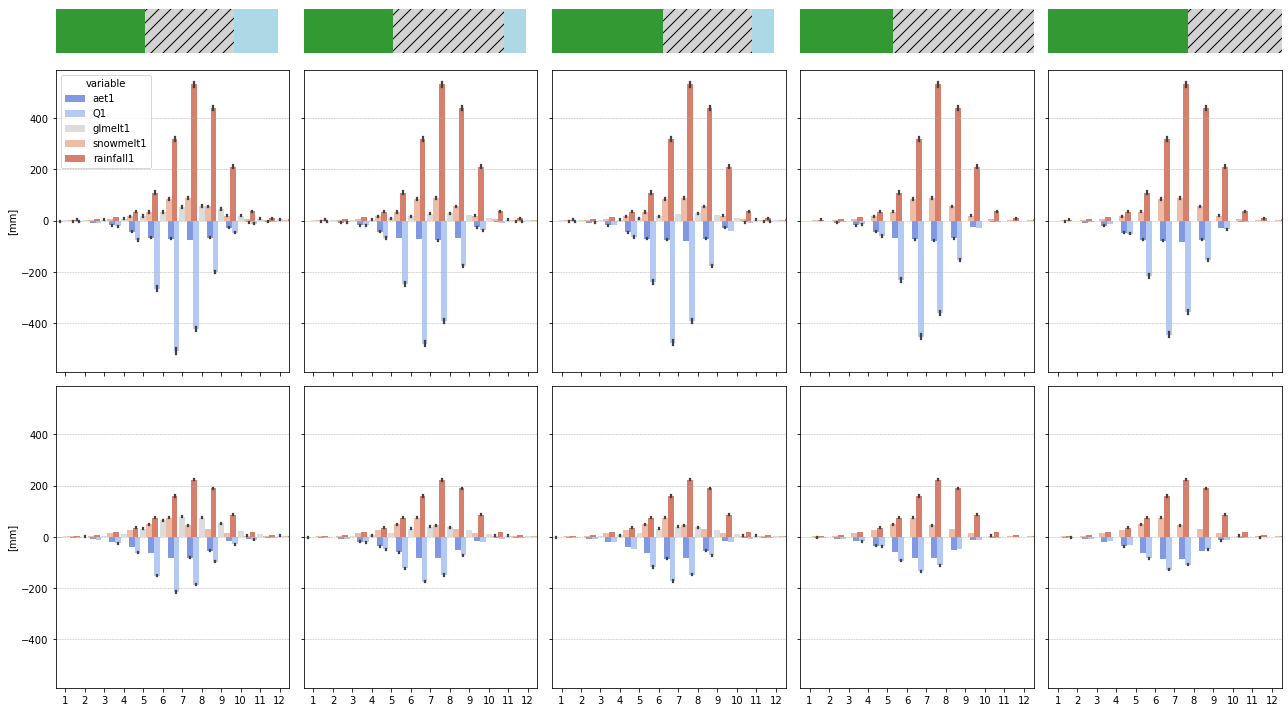

In [42]:
fig = plt.figure(figsize=(18, 10), layout='tight')
mosaic = fig.subplot_mosaic('''
                            klmno
                            abcde
                            abcde
                            abcde
                            abcde
                            abcde
                            ABCDE
                            ABCDE
                            ABCDE
                            ABCDE
                            ABCDE
                            ''')


palette = 'coolwarm'


# axa = mosaic['a'].twinx()
# axb = mosaic['b'].twinx()
# axc = mosaic['c'].twinx()
# axd = mosaic['d'].twinx()
# axe = mosaic['e'].twinx()

# axA = mosaic['A'].twinx()
# axB = mosaic['B'].twinx()
# axC = mosaic['C'].twinx()
# axD = mosaic['D'].twinx()
# axE = mosaic['E'].twinx()





sns.barplot(data=combined_df,  x="month", y="value", hue="variable", ax=mosaic['a'], palette = palette, dodge=True, width=1.5)
sns.barplot(data=combined_df2, x="month", y="value", hue="variable", ax=mosaic['b'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df3, x="month", y="value", hue="variable", ax=mosaic['c'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df4, x="month", y="value", hue="variable", ax=mosaic['d'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df5, x="month", y="value", hue="variable", ax=mosaic['e'], palette = palette, dodge=True, width=1.5, legend = False)

sns.barplot(data=combined_dfm,  x="month", y="value", hue="variable", ax=mosaic['A'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df2m, x="month", y="value", hue="variable", ax=mosaic['B'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df3m, x="month", y="value", hue="variable", ax=mosaic['C'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df4m, x="month", y="value", hue="variable", ax=mosaic['D'], palette = palette, dodge=True, width=1.5, legend = False)
sns.barplot(data=combined_df5m, x="month", y="value", hue="variable", ax=mosaic['E'], palette = palette, dodge=True, width=1.5, legend = False)





# sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=axa, errorbar='ci')
# sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=axb, errorbar='sd')
# sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=axc, errorbar='sd')
# sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=axd, errorbar='sd')
# sns.lineplot(data=Ta_langtang,  x="month", y="value", ax=axe, errorbar='sd')




# sns.lineplot(data=Ta_mustang,  x="month", y="value", ax=axA, errorbar='sd')
# sns.lineplot(data=Ta_mustang,  x="month", y="value", ax=axB, errorbar='sd')
# sns.lineplot(data=Ta_mustang,  x="month", y="value", ax=axC, errorbar='sd')
# sns.lineplot(data=Ta_mustang,  x="month", y="value", ax=axD, errorbar='sd')
# sns.lineplot(data=Ta_mustang,  x="month", y="value", ax=axE, errorbar='sd')


for key in ['a', 'b', 'c', 'd', 'e']:
    mosaic[key].set_xticklabels([])


for key in ['a', 'b', 'c', 'd', 'e', 'A', 'B', 'C', 'D', 'E']:
    mosaic[key].set_xlabel('')

for key in ['a', 'A']: 
    mosaic[key].set_ylabel('[mm]')


for key in ['b', 'c', 'd', 'e', 'B', 'C', 'D', 'E']:
    mosaic[key].set_ylabel('')
    mosaic[key].set_yticklabels([])


for key in ['a', 'b', 'c', 'd', 'e', 'A', 'B', 'C', 'D', 'E']:
    # mosaic[key].set_xlabel('month')
    mosaic[key].set_ylim(-590, 590)
    # mosaic[key].set_ylim(-0.6, 0.8)

for key in ['a', 'b', 'c', 'd', 'e', 'A', 'B', 'C', 'D', 'E']:
    mosaic[key].grid(axis='y', linestyle='--', linewidth=0.5) 


# color bar for land cover shares 

# Define color proportions for each panel (Green, Yellow, Gray)
shares = [
    (40, 40, 20),  # First bar: 40% green (veg) , 30% grey (bedrock), 30% blue (glacier)
    (40, 50, 10),
    (50, 40, 10),
    (40, 60, 00),
    (60, 40, 00),
]

# Iterate over the bar row and create the proportional bars
for i, key in enumerate("klmno"):
    bar_ax = mosaic[key]  # Select the correct subplot for the bar

    # Remove ticks, labels, and spines
    bar_ax.set_xticks([])
    bar_ax.set_yticks([])
    bar_ax.set_frame_on(False)

    # Extract proportions (must sum to 100%)
    p1, p2, p3 = shares[i]  # Green, Yellow, Gray

    # Convert percentages to width (normalized to 1)
    p1 /= 100
    p2 /= 100
    p3 /= 100

    # Plot the three segments
    bar_ax.barh(0, p1, height=1, color='green', align='center', alpha = 0.8)
    bar_ax.barh(0, p2, height=1, color='lightgray', left=p1, align='center', hatch = '//')
    bar_ax.barh(0, p3, height=1, color='lightblue', left=p1 + p2, align='center')


# plt.savefig('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/monthly_WB_components.png', bbox_inches = 'tight', dpi = 300)

# plot per elevation

In [ ]:
'''
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Group data
mean_df = (
    combined_dfm
    .groupby(['month', 'elevation_bin', 'variable'])['value']
    .mean()
    .reset_index()
)

# Unique variables and months
variables = mean_df['variable'].unique()
months = sorted(mean_df['month'].unique())
elevation_bins = sorted(mean_df['elevation_bin'].unique())

# Create magma colormap
cmap = cm.get_cmap('magma', len(months))
colors = [cmap(i) for i in range(len(months))]

num_vars = len(variables)

fig, axes = plt.subplots(1, num_vars, figsize=(6*num_vars, 6), sharey=True)

# If only one variable, axes may not be an array — fix that:
if num_vars == 1:
    axes = [axes]

for ax, var in zip(axes, variables):
    df_var = mean_df[mean_df['variable'] == var]

    for i, month in enumerate(months):
        df_month = df_var[df_var['month'] == month]

        lw = 2.5 if month in [5, 6, 7, 8, 9] else 0.3

        ax.plot(
            df_month['value'],
            df_month['elevation_bin'],
            label=f'Month {month}',
            color=colors[i],
            linewidth=lw
        )

    ax.set_title(f'{var}')
    ax.set_xlabel('Mean Value')
    ax.grid(True)

axes[0].set_ylabel('Elevation Bin')

# Put one legend for all subplots, outside the plot area
fig.legend(
    handles=axes[0].get_lines(),
    labels=[f'Month {m}' for m in months],
    title='Month',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(months)
)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space on top for legend
plt.show()
'''

# LANGTANG

In [67]:

def group_data(data):
    grouped = (
        data.groupby(['month', 'elevation_bin', 'variable'])['value']
        .mean()
        .reset_index()
    )
    return grouped

dataframes = [combined_df, combined_df2, combined_df3, combined_df4, combined_df5]

grouped_dfs = []  # to store the new grouped dataframes

for df in dataframes:
    grouped_df = group_data(df)
    grouped_df['variable'] = grouped_df['variable'].str.replace(r'\d+$', '', regex=True)

    grouped_dfs.append(grouped_df)



In [68]:
# combined_df2[combined_df2.elevation_bin == '2500']

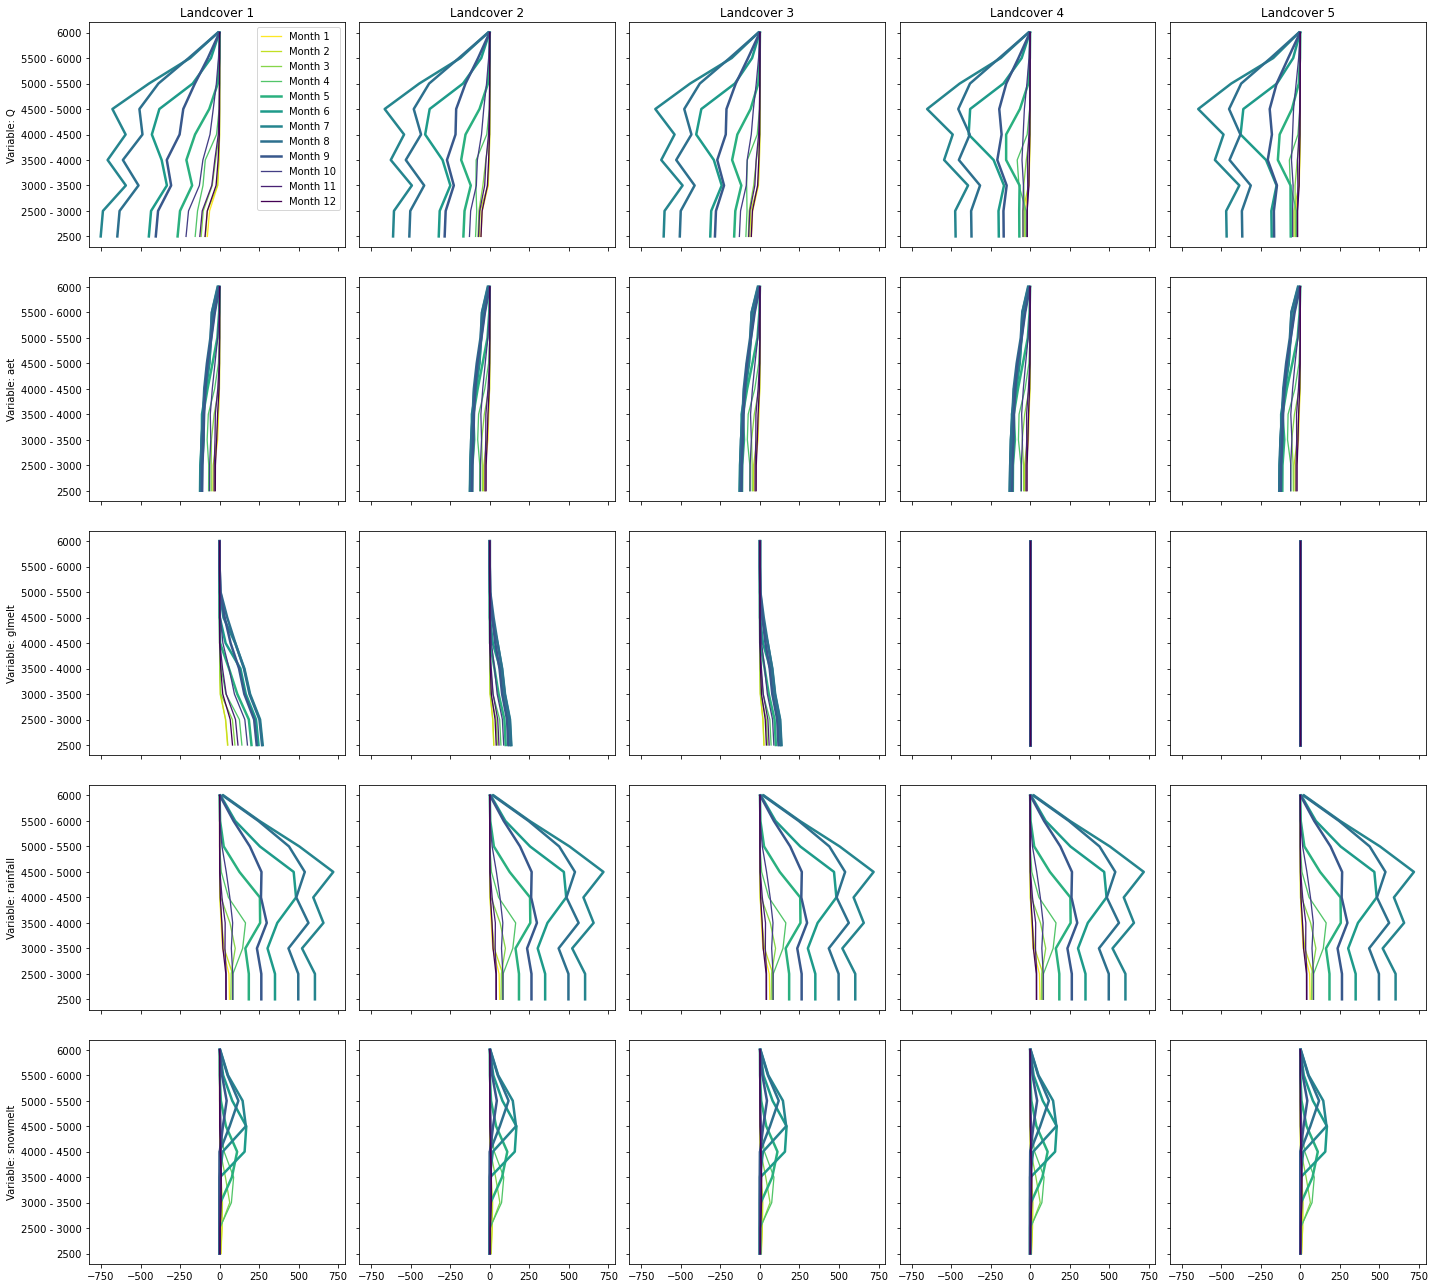

In [69]:

# Unique variables and monthsd
variables = grouped_dfs[0]['variable'].unique()
months = sorted(grouped_dfs[0]['month'].unique())
elevation_bins = sorted(grouped_dfs[0]['elevation_bin'].unique())


# Create magma colormap
cmap = cm.get_cmap('viridis_r', len(months))
colors = [cmap(i) for i in range(len(months))]

num_vars = len(variables)
num_dfs = len(grouped_dfs)  # should be 5 for your 5 rows

# fig, axes = plt.subplots(num_dfs, num_vars, figsize=(6*num_vars, 5*num_dfs), sharey=True, sharex=True)
fig, axes = plt.subplots(num_dfs, num_vars, figsize=(20, 18), sharey=True, sharex=True)



# Fix axes if there's only one row or column
if num_dfs == 1:
    axes = [axes]
if num_vars == 1:
    axes = [[ax] for ax in axes]

for row_idx, df in enumerate(grouped_dfs):
    for col_idx, var in enumerate(variables):
        # ax = axes[row_idx][col_idx]
        ax = axes[col_idx][row_idx]

        df_var = df[df['variable'] == var]

        for i, month in enumerate(months):
            df_month = df_var[df_var['month'] == month]

            lw = 2.5 if month in [5, 6, 7, 8, 9] else 1.3

            ax.plot(
                df_month['value'],
                df_month['elevation_bin'],
                label=f'Month {month}',
                color=colors[i],
                linewidth=lw
            )
        
        if row_idx == 0:
            # ax.set_title(f'Variable: {var}')
            ax.set_ylabel(f'Variable: {var}')
        if col_idx == 0:
            # ax.set_ylabel(f'DataFrame {row_idx + 1}')
            ax.set_title(f'Landcover {row_idx + 1}')

        # ax.invert_yaxis()

        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=10)




plt.tight_layout()


# plt.savefig('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/langtang_hydrology_elevation.png', bbox_inches = 'tight', dpi = 300)
# plt.savefig('/Users/varyabazilova/Desktop/paper2/plots_experiments/langtang_hydrology_elevation.png', bbox_inches = 'tight', dpi = 300)

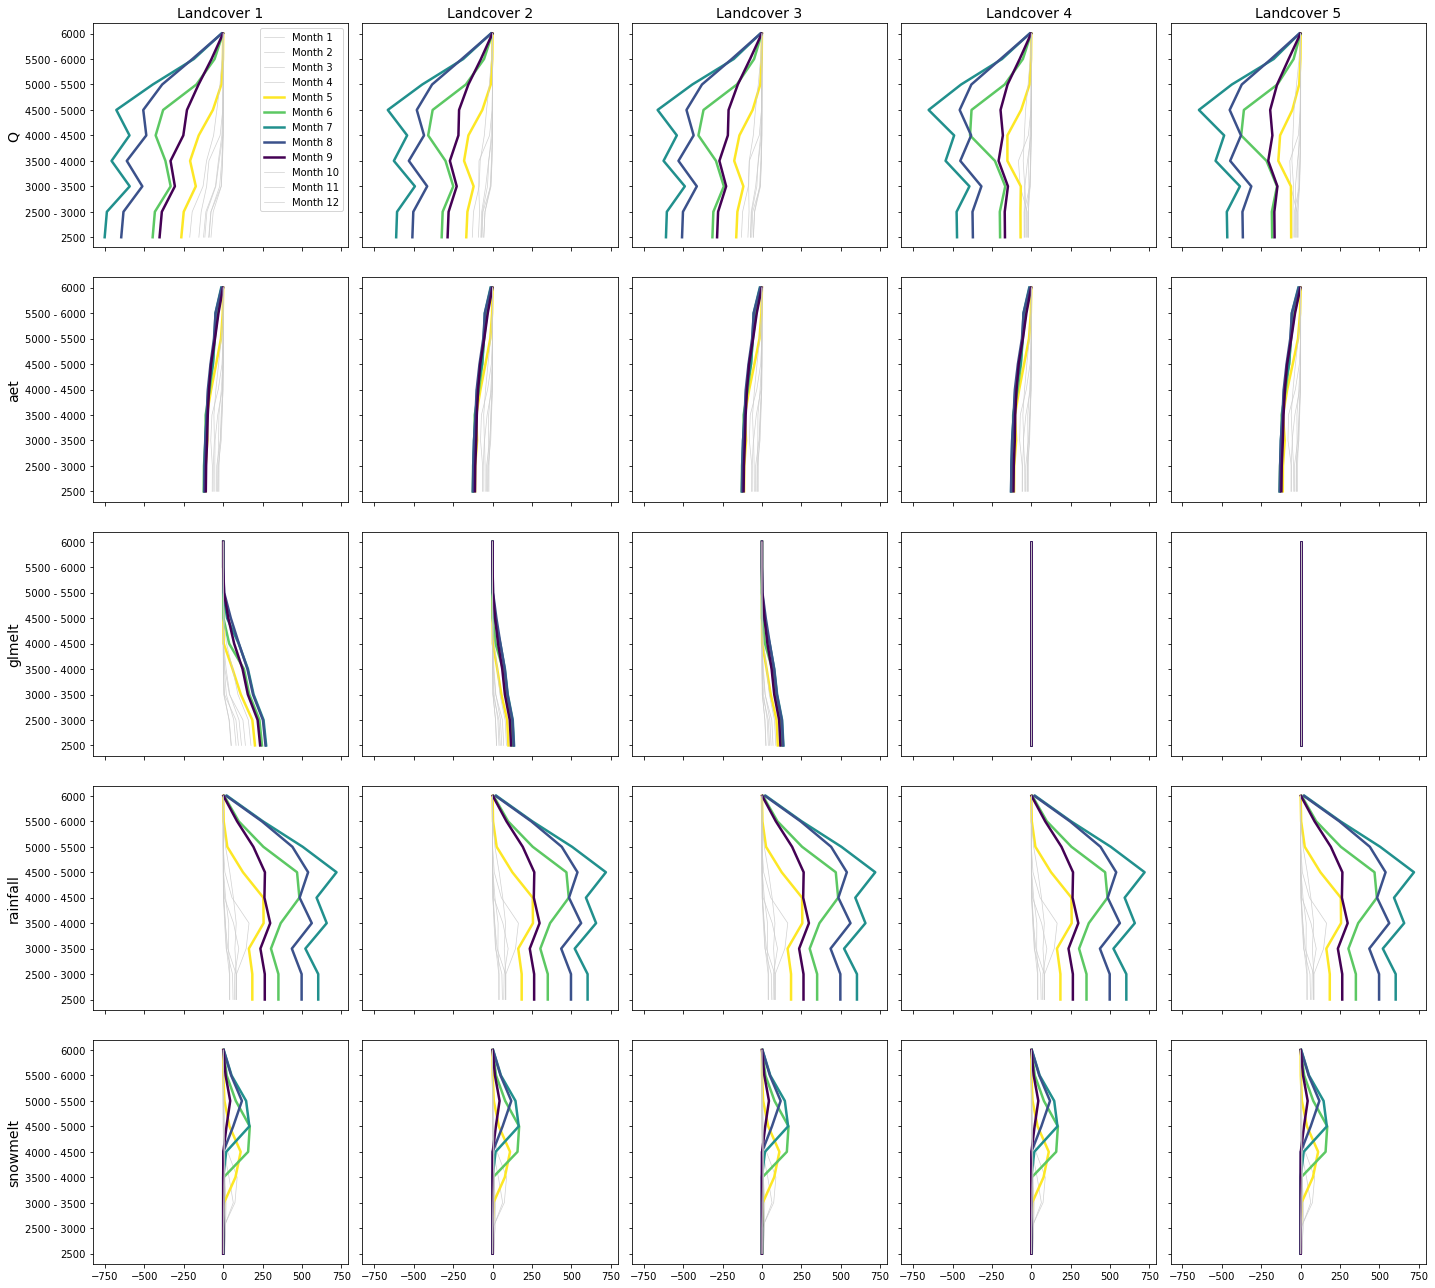

In [70]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable




# Unique variables and months
variables = grouped_dfs[0]['variable'].unique()
months = sorted(grouped_dfs[0]['month'].unique())
elevation_bins = sorted(grouped_dfs[0]['elevation_bin'].unique())

# Define which months to highlight (colorbar stretched over these)
highlight_months = [5, 6, 7, 8, 9]
cmap = cm.get_cmap('viridis_r', len(highlight_months))

# Assign colors: vivid for 5–9, light gray for others
colors = {}
for month in months:
    if month in highlight_months:
        idx = highlight_months.index(month)
        colors[month] = cmap(idx)
    else:
        colors[month] = (0.8, 0.8, 0.8, 0.9)  # light gray with transparency

# Prepare figure
num_vars = len(variables)
num_dfs = len(grouped_dfs)  # should be 5 for your 5 rows
fig, axes = plt.subplots(num_dfs, num_vars, figsize=(20, 18), sharey=True, sharex=True)

fig.patch.set_facecolor('xkcd:white')



# Fix axes shape for 1-row or 1-column cases
if num_dfs == 1:
    axes = [axes]
if num_vars == 1:
    axes = [[ax] for ax in axes]

# Plotting
for row_idx, df in enumerate(grouped_dfs):
    for col_idx, var in enumerate(variables):
        ax = axes[col_idx][row_idx]
        
        df_var = df[df['variable'] == var]

        for month in months:
            df_month = df_var[df_var['month'] == month]
            lw = 2.5 if month in highlight_months else 0.7

            ax.plot(
                df_month['value'],
                df_month['elevation_bin'],
                label=f'Month {month}',
                color=colors[month],
                linewidth=lw
            )

        if row_idx == 0:
            ax.set_ylabel(f'{var}', fontsize = 14)
        if col_idx == 0:
            ax.set_title(f'Landcover {row_idx + 1}', fontsize = 14)
        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=10)

plt.tight_layout()

# Save the figure (uncomment if needed)
# plt.savefig('/path/to/your/output.png', bbox_inches='tight', dpi=300)

# plt.savefig('/Users/varyabazilova/Desktop/paper2/plots_experiments/langtang_hydrology_elevation2.png', bbox_inches = 'tight', dpi = 300)

## calculate %

In [47]:
lc1 = grouped_dfs[0]
lc1 = lc1[lc1.variable.str.strip().isin(['glmelt'])]#, 'Q'])]
lc1 = lc1[lc1.elevation_bin == '2500']
lc1 = lc1.sort_values('variable')
lc1

,month,elevation_bin,variable,value
2,1,2500,glmelt,49.875794
47,2,2500,glmelt,51.794207
92,3,2500,glmelt,96.773627
137,4,2500,glmelt,140.864470
182,5,2500,glmelt,201.512755
227,6,2500,glmelt,246.114702
272,7,2500,glmelt,272.591474
317,8,2500,glmelt,268.557994
362,9,2500,glmelt,234.398266
407,10,2500,glmelt,176.038061


In [48]:
lc2 = grouped_dfs[1]
lc2 = lc2[lc2.variable.str.strip().isin(['glmelt'])]#, 'Q'])]
lc2 = lc2[lc2.elevation_bin == '2500']
lc2 = lc2.sort_values('month')
lc2

,month,elevation_bin,variable,value
2,1,2500,glmelt,24.937897
47,2,2500,glmelt,25.897103
92,3,2500,glmelt,48.386814
137,4,2500,glmelt,70.432235
182,5,2500,glmelt,100.756378
227,6,2500,glmelt,123.057351
272,7,2500,glmelt,136.295737
317,8,2500,glmelt,134.278997
362,9,2500,glmelt,117.199133
407,10,2500,glmelt,88.019031


In [49]:

test = combined_df2m.groupby(['month', 'elevation_bin', 'variable'])['value'].mean().reset_index()



In [50]:
test1 = test[test.variable == 'glmelt2']
test1


,month,elevation_bin,variable,value
2,1,2500 - 3000,glmelt2,11.545087
7,1,3000 - 3500,glmelt2,4.712999
12,1,3500 - 4000,glmelt2,2.071880
17,1,4000 - 4500,glmelt2,0.687510
22,1,4500 - 5000,glmelt2,0.088758
...,...,...,...,...
457,12,4000 - 4500,glmelt2,2.612688
462,12,4500 - 5000,glmelt2,0.480991
467,12,5000 - 5500,glmelt2,0.028517
472,12,5500 - 6000,glmelt2,0.000998


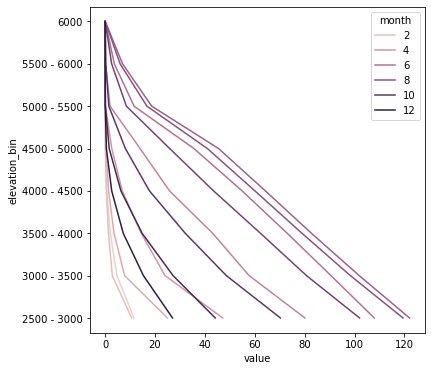

In [51]:
# Create the plot
plt.figure(figsize=(6, 6))
sns.lineplot(data=test1, x='value', y='elevation_bin', hue='month')
plt.gca().invert_yaxis()


In [52]:
combined_df2m

,year,month,elevation,value,elevation_bin,date_id,landcover,variable,type
398,1989,10,2546,-54.735911,2500 - 3000,1989_10_2546,landcover 2,aet2,aet2
1192,1989,10,2571,-54.733907,2500 - 3000,1989_10_2571,landcover 2,aet2,aet2
5162,1989,10,2779,-42.825137,2500 - 3000,1989_10_2779,landcover 2,aet2,aet2
1589,1989,10,2886,-56.772616,2500 - 3000,1989_10_2886,landcover 2,aet2,aet2
14690,1989,10,2981,-35.802536,2500 - 3000,1989_10_2981,landcover 2,aet2,aet2
...,...,...,...,...,...,...,...,...,...
32553,2022,9,5895,29.314548,5500 - 6000,2022_9_5895,landcover 2,rainfall2,rainfall2
69077,2022,9,5908,82.045475,5500 - 6000,2022_9_5908,landcover 2,rainfall2,rainfall2
69871,2022,9,5909,81.870300,5500 - 6000,2022_9_5909,landcover 2,rainfall2,rainfall2
33744,2022,9,5960,19.875629,5500 - 6000,2022_9_5960,landcover 2,rainfall2,rainfall2


# MUSTANG

In [53]:


dataframes = [combined_dfm, combined_df2m, combined_df3m, combined_df4m, combined_df5m]

grouped_dfs = []  # to store the new grouped dataframes

for df in dataframes:
    grouped_df = group_data(df)
    grouped_df['variable'] = grouped_df['variable'].str.replace(r'\d+$', '', regex=True)

    grouped_dfs.append(grouped_df)



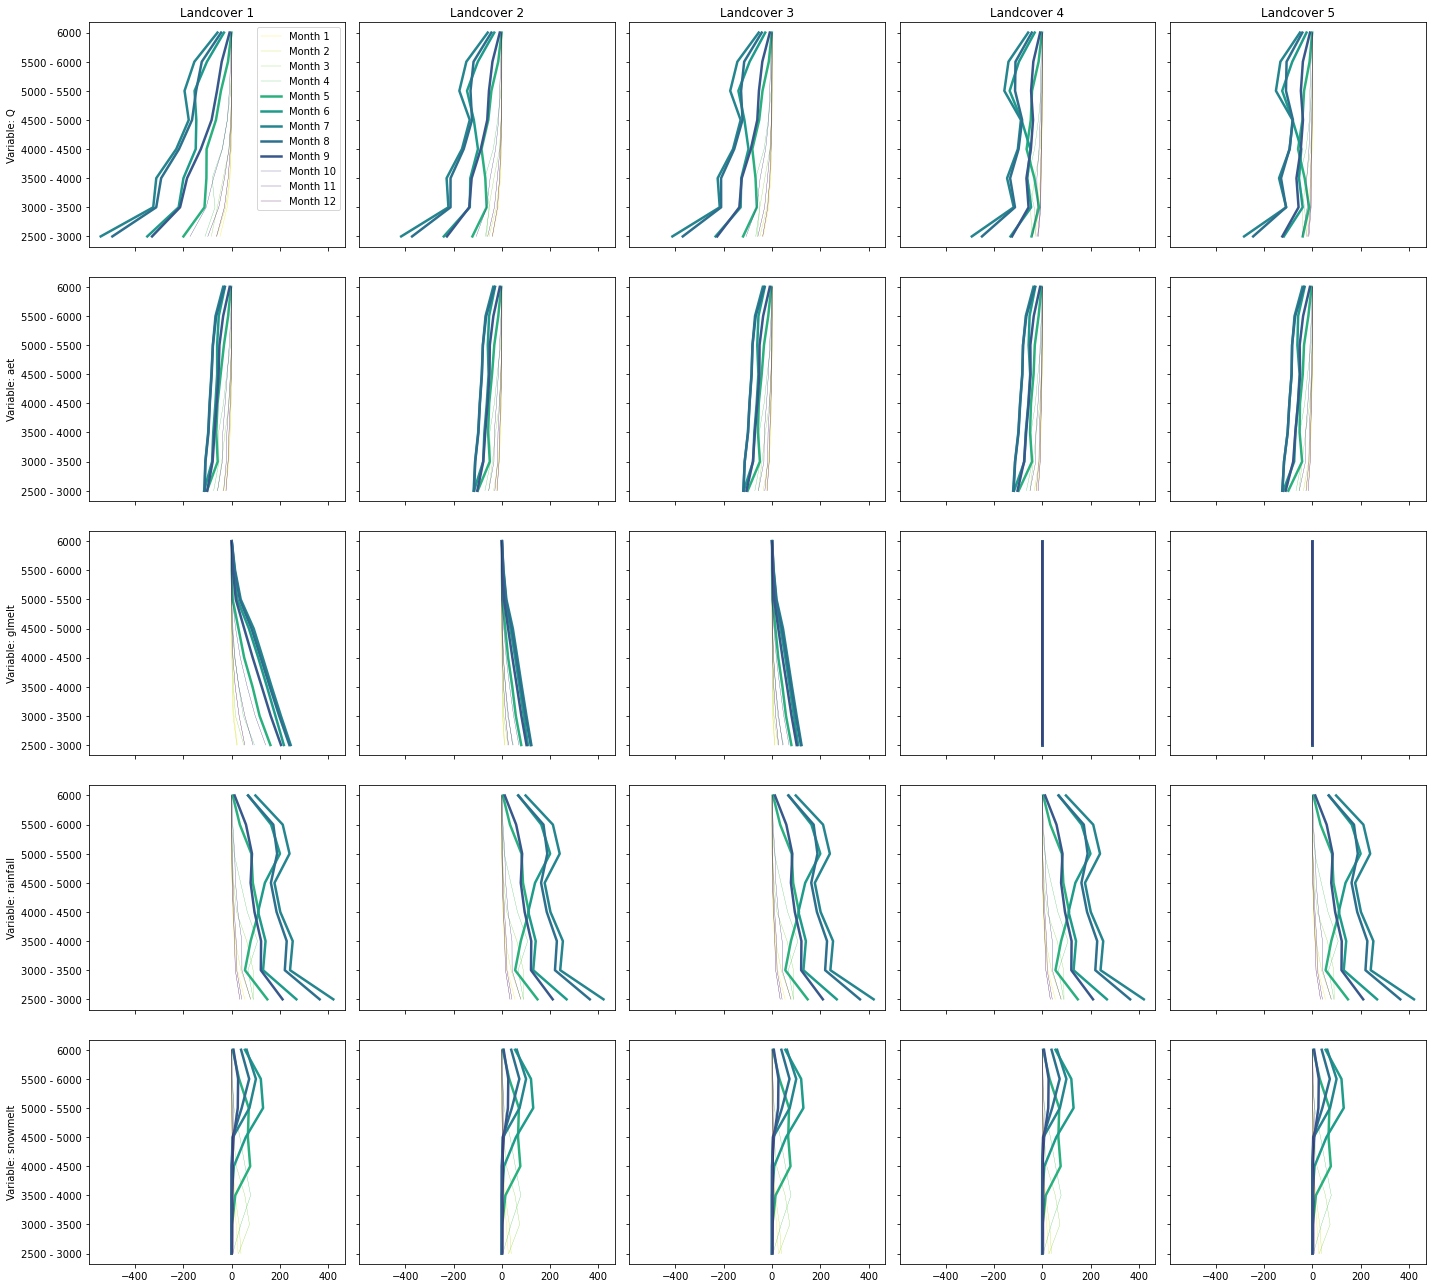

In [54]:

# Unique variables and monthsd
variables = grouped_dfs[0]['variable'].unique()
months = sorted(grouped_dfs[0]['month'].unique())
elevation_bins = sorted(grouped_dfs[0]['elevation_bin'].unique())


# Create magma colormap
cmap = cm.get_cmap('viridis_r', len(months))
colors = [cmap(i) for i in range(len(months))]

num_vars = len(variables)
num_dfs = len(grouped_dfs)  # should be 5 for your 5 rows

# fig, axes = plt.subplots(num_dfs, num_vars, figsize=(6*num_vars, 5*num_dfs), sharey=True, sharex=True)
fig, axes = plt.subplots(num_dfs, num_vars, figsize=(20, 18), sharey=True, sharex=True)



# Fix axes if there's only one row or column
if num_dfs == 1:
    axes = [axes]
if num_vars == 1:
    axes = [[ax] for ax in axes]

for row_idx, df in enumerate(grouped_dfs):
    for col_idx, var in enumerate(variables):
        # ax = axes[row_idx][col_idx]
        ax = axes[col_idx][row_idx]

        df_var = df[df['variable'] == var]

        for i, month in enumerate(months):
            df_month = df_var[df_var['month'] == month]

            lw = 2.5 if month in [5, 6, 7, 8, 9] else 0.3

            ax.plot(
                df_month['value'],
                df_month['elevation_bin'],
                label=f'Month {month}',
                color=colors[i],
                linewidth=lw
            )
        
        if row_idx == 0:
            # ax.set_title(f'Variable: {var}')
            ax.set_ylabel(f'Variable: {var}')
        if col_idx == 0:
            # ax.set_ylabel(f'DataFrame {row_idx + 1}')
            ax.set_title(f'Landcover {row_idx + 1}')

        # ax.invert_yaxis()

        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=10)



plt.tight_layout()


# plt.savefig('/Users/varyabazilova/Desktop/paper2/plots_experiments/mustang_hydrology_elevation.png', bbox_inches = 'tight', dpi = 300)
# plt.savefig('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/mustang_hydrology_elevation.png', bbox_inches = 'tight', dpi = 300)

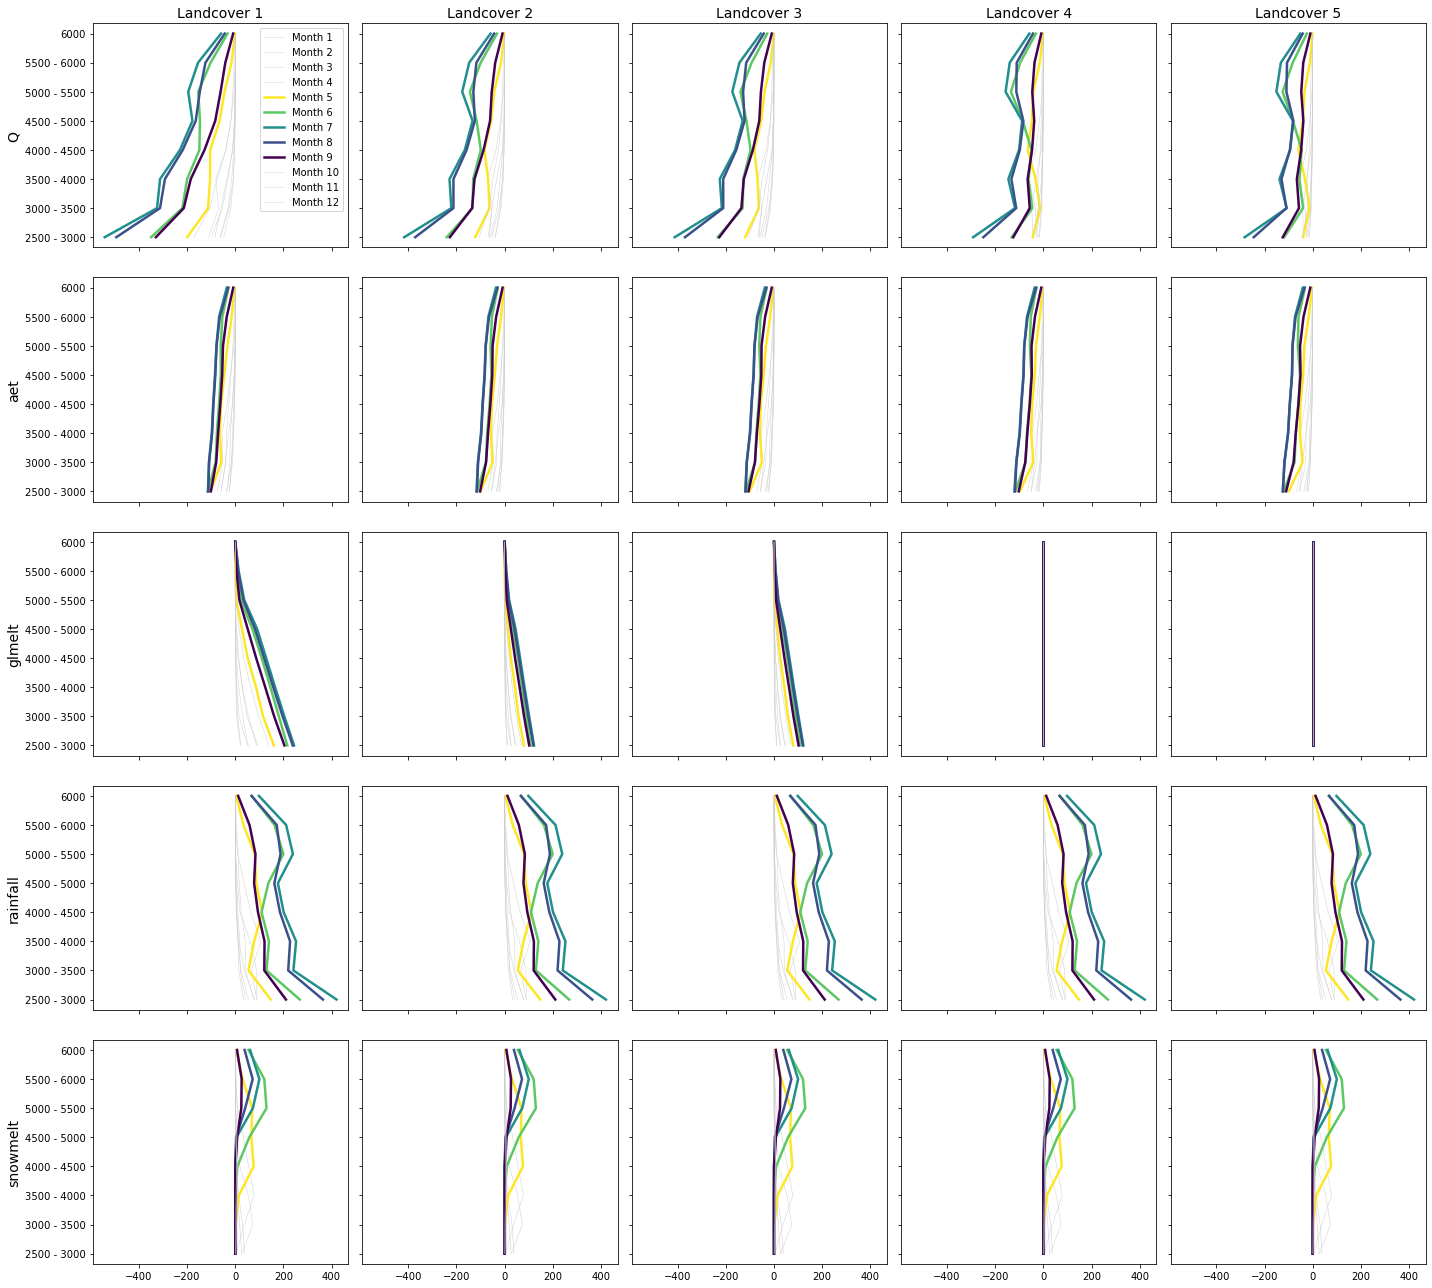

In [55]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Unique variables and months
variables = grouped_dfs[0]['variable'].unique()
months = sorted(grouped_dfs[0]['month'].unique())
elevation_bins = sorted(grouped_dfs[0]['elevation_bin'].unique())

# Define which months to highlight (colorbar stretched over these)
highlight_months = [5, 6, 7, 8, 9]
cmap = cm.get_cmap('viridis_r', len(highlight_months))

# Assign colors: vivid for 5–9, light gray for others
colors = {}
for month in months:
    if month in highlight_months:
        idx = highlight_months.index(month)
        colors[month] = cmap(idx)
    else:
        colors[month] = (0.8, 0.8, 0.8, 0.9)  # light gray with transparency

# Prepare figure
num_vars = len(variables)
num_dfs = len(grouped_dfs)  # should be 5 for your 5 rows
fig, axes = plt.subplots(num_dfs, num_vars, figsize=(20, 18), sharey=True, sharex=True)
fig.patch.set_facecolor('xkcd:white')

# Fix axes shape for 1-row or 1-column cases
if num_dfs == 1:
    axes = [axes]
if num_vars == 1:
    axes = [[ax] for ax in axes]

# Plotting
for row_idx, df in enumerate(grouped_dfs):
    for col_idx, var in enumerate(variables):
        ax = axes[col_idx][row_idx]
        df_var = df[df['variable'] == var]

        for month in months:
            df_month = df_var[df_var['month'] == month]
            lw = 2.5 if month in highlight_months else 0.5

            ax.plot(
                df_month['value'],
                df_month['elevation_bin'],
                label=f'Month {month}',
                color=colors[month],
                linewidth=lw
            )

        if row_idx == 0:
            ax.set_ylabel(f'{var}', fontsize = 14)
        if col_idx == 0:
            ax.set_title(f'Landcover {row_idx + 1}', fontsize = 14)
        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=10)

plt.tight_layout()

# Save the figure (uncomment if needed)
# plt.savefig('/path/to/your/output.png', bbox_inches='tight', dpi=300)

# plt.savefig('/Users/varyabazilova/Desktop/paper2/plots_experiments/mustang_hydrology_elevation2.png', bbox_inches = 'tight', dpi = 300)
